In [1]:
import csv
import os
import pandas as pd
import numpy as np
import copy
import time
import pickle
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.preprocessing import normalize, MinMaxScaler

import sklearn.model_selection as model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

In [2]:
# usefull fucntions
def remove_nan_values(sample_array:np.array) -> np.array:
    for sample_index, i in enumerate(sample_array):
        for value_index, j in enumerate(i):
            if np.isnan(j):
               sample_array[sample_index][value_index] = 0.0
    return sample_array

def remove_1d_array_nan_values(sample_array: np.array, attack_categories: dict) -> np.array:
    for value_index, j in enumerate(sample_array):
        if j==' ':
           sample_array[value_index] = 0.0
        elif type(j) == str:
            try:
                sample_array[value_index] = int(j)
            except:
                sample_array[value_index] = attack_categories[j]
        elif np.isnan(j):
           sample_array[value_index] = 0.0
    return sample_array

def save_model(model, meta) -> None:
    """Function responsible for saving trained model. It must be called
    after defining, training and predict.

    :param: None
    :return: None
    """

    filename = f"finalized_{meta}_{model}.sav"
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filepath):
    """Function responsible for load model.

    :param: None
    :return: None
    """
    return pickle.load(open(filepath, 'rb'))

## Load data

In [3]:
dataset_path = '../../Datasets/CIC-IDS2017/MachineLearningCVE'
os.listdir(dataset_path)

['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv']

In [4]:
csv_files = [os.path.join(dataset_path,file) for file in os.listdir(dataset_path)]

In [5]:
# load multiple files
li = []
df = None
for csv_file in csv_files:
    df = pd.read_csv(csv_file, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, ignore_index=True)

In [6]:
labels = {value: index for index, value in enumerate(list(frame[' Label'].unique()))}
labels_binary = {value: 1 for index, value in enumerate(labels) if index!=0}
labels_binary['BENIGN'] = 0

In [25]:
frame[frame[' Label'] == 'BENIGN'][' Label']

0          BENIGN
1          BENIGN
2          BENIGN
3          BENIGN
4          BENIGN
            ...  
2830738    BENIGN
2830739    BENIGN
2830740    BENIGN
2830741    BENIGN
2830742    BENIGN
Name:  Label, Length: 2273097, dtype: object

In [32]:
frame.replace('BENIGN', 'Normal', inplace=True)
frame.replace('PortScan', 'Scanning', inplace=True)
frame.replace('DoS slowloris', 'Dos', inplace=True)
frame.replace('DoS Slowhttptest', 'Dos', inplace=True)
frame.replace('Dos Hulk', 'Dos', inplace=True)
frame.replace('Web Attack � Brute Force', 'Brute Force', inplace=True)
frame.replace('Web Attack � Sql Injection', 'Sql Injection', inplace=True)
frame.replace('Web Attack � XSS', 'XSS', inplace=True)
frame.replace('DoS GoldenEye', 'Dos', inplace=True)
# frame.replace('DoS GoldenEye', 'Dos', inplace=True)

In [33]:
frame[' Label'].unique()

array(['Normal', 'Scanning', 'Infiltration', 'Dos', 'DoS Hulk',
       'Heartbleed', 'Brute Force', 'XSS', 'Sql Injection', 'DDoS',
       'FTP-Patator', 'SSH-Patator', 'Bot'], dtype=object)

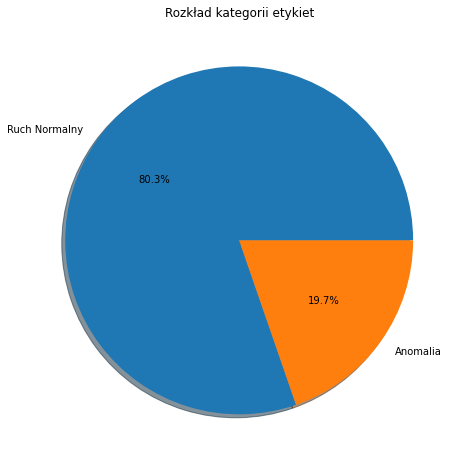

In [11]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii etykiet")
plt.pie([frame[frame[' Label'] == 'BENIGN'].shape[0], frame[frame[' Label'] != 'BENIGN'].shape[0]],
       labels=['Ruch Normalny', 'Anomalia'], autopct='%1.1f%%', shadow=True)
plt.show()

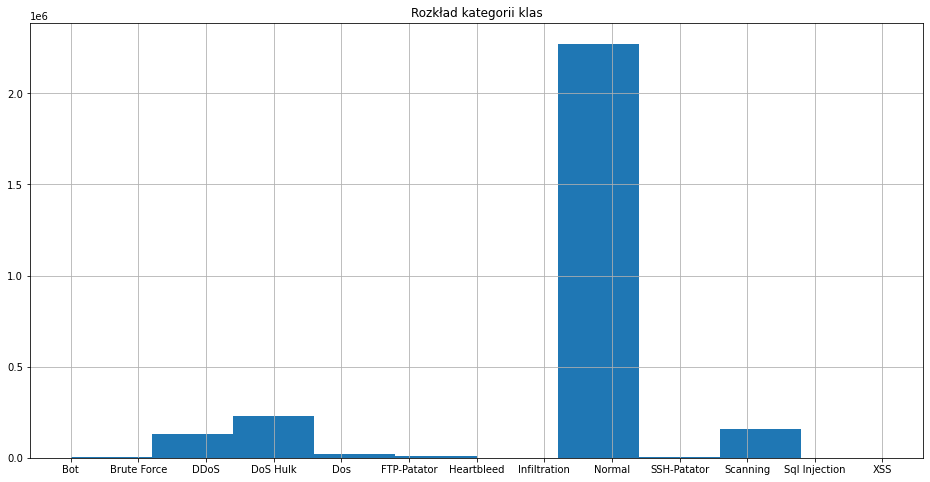

In [34]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii klas")
plt.hist(frame[' Label'].sort_values())
plt.show()

## Binary classification

In [7]:
# prepare data for classification
chosen_features = list(frame.columns)[1:-1]

x_data = frame[chosen_features].fillna(0.0)
x_data = x_data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

x_data = x_data.to_numpy()
y_data = np.array([labels_binary[i] for i in frame[' Label']])

In [8]:
# splt data to training and testing set
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data,
                                                                    train_size=0.80,
                                                                    test_size=0.20,
                                                                    random_state=101)
# remove nan values
# x_train, x_test = remove_nan_values(x_train), remove_nan_values(x_test)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# normalization min max
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [9]:
model = GaussianNB()

model.fit(x_train, y_train)

GaussianNB()

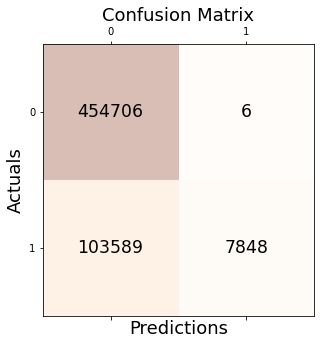

In [19]:
prediction = model.predict(x_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [22]:
accuracy = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction, average='weighted')
recall = recall_score(y_test, prediction, average='weighted')
f1_ = f1_score(y_test, prediction, average='weighted')

print(accuracy, precision, recall, f1_)

0.817018134801969 0.8508258514119941 0.817018134801969 0.7469297668973225


In [10]:
models = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)]


models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30, 15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]


In [10]:
models_mlp2 = [models_mlp[-2], models_mlp[-1]]

In [10]:
# train models
for model in models:
    model.fit(x_train, y_train)
    print(model)

GaussianNB()
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10)
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                         min_impurity_decrease=6e-05,
                                                

In [12]:
predictions = {i: None for i in models}
for model, model_str in zip(models, predictions):
    predictions[model_str] = model.predict(x_test)

In [13]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='weighted')
    recall = recall_score(y_test, predictions[model_str], average='weighted')
    f1_ = f1_score(y_test, predictions[model_str], average='weighted')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,GaussianNB(),81.7,85.1,81.7,74.7
1,DecisionTreeClassifier(class_weight='balanced'...,99.6,99.6,99.6,99.6
2,"(DecisionTreeClassifier(criterion='entropy', m...",99.1,99.1,99.1,99.1
3,"MLPClassifier(hidden_layer_sizes=(15, 30, 60),...",95.7,95.6,95.7,95.6
4,(DecisionTreeClassifier(class_weight='balanced...,96.0,96.0,96.0,95.9
5,([DecisionTreeRegressor(criterion='friedman_ms...,98.3,98.3,98.3,98.3


In [11]:
for model in models_mlp:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)


/home/mkubita/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)


/home/mkubita/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(200, 200, 200), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(300, 150, 75), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)


/home/mkubita/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [11]:
for model in models_mlp2:
    model.fit(x_train, y_train)

In [13]:
predictions = {i: None for i in models_mlp2}
for model, model_str in zip(models_mlp2, predictions):
    predictions[model_str] = model.predict(x_test)

In [14]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models_mlp2, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='weighted')
    recall = recall_score(y_test, predictions[model_str], average='weighted')
    f1_ = f1_score(y_test, predictions[model_str], average='weighted')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models_mlp2,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",96.2,96.2,96.2,96.1
1,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",96.8,96.8,96.8,96.8


In [13]:
predictions = {i: None for i in models_mlp[:-2]}
for model, model_str in zip(models_mlp[:-2], predictions):
    predictions[model_str] = model.predict(x_test)

In [14]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models_mlp[:-2], predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='weighted')
    recall = recall_score(y_test, predictions[model_str], average='weighted')
    f1_ = f1_score(y_test, predictions[model_str], average='weighted')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models_mlp[:-2],
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",90.8,93.6,90.8,91.4
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",95.0,94.9,95.0,94.9
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",94.1,94.0,94.1,93.9
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",95.6,95.6,95.6,95.4
4,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",95.3,95.3,95.3,95.3
5,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",93.8,93.9,93.8,93.4
6,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",95.5,95.5,95.5,95.3
7,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",98.1,98.1,98.1,98.1


In [11]:
for model in models_mlp_downsampling:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [12]:
predictions = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions):
    predictions[model_str] = model.predict(x_test)

In [13]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list, fpr_list = [], [], [], [], []
for model, model_str in zip(models_mlp_downsampling, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='weighted')
    recall = recall_score(y_test, predictions[model_str], average='weighted')
    f1_ = f1_score(y_test, predictions[model_str], average='weighted')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",89.3,92.9,89.3,90.1
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",92.9,92.7,92.9,92.7
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",92.9,92.8,92.9,92.8
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",94.0,93.9,94.0,93.9
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",80.9,90.2,80.9,82.7
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",94.0,95.0,94.0,94.2
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",94.1,94.1,94.1,94.1
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",95.0,94.9,95.0,94.9
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",88.0,91.1,88.0,88.8


In [15]:
x_train.shape

(2264594, 77)

In [14]:
import csv
import os
import pandas as pd
import numpy as np
import copy
import time
import pickle
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Activation, GRU
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

import sklearn.model_selection as model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve
import matplotlib.pyplot as plt

2022-07-09 15:02:36.762674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 15:02:36.762694: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
model = Sequential()
# model.add(Embedding(64, 42, input_length=64))

# !!! Play with those! try and get better results!
#model.add(SimpleRNN(128))  
#model.add(GRU(128))  
model.add(LSTM(300, activation="tanh", return_sequences = True, input_shape = (77, 1)))
model.add(Dropout(0.4))

model.add(LSTM(200, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(100, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(80, activation="tanh"))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-07-09 15:03:32.494203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 15:03:32.494539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 15:03:32.494602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-09 15:03:32.494657: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-09 15:03:32.516368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [17]:
model.fit(x_train, y_train, batch_size=64, 
          epochs=20, validation_data=(x_test, y_test))


Epoch 1/20


2022-07-09 15:03:47.972266: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 697494952 exceeds 10% of free system memory.


35385/35385 [==============================] - 15455s 437ms/step - loss: 0.4978 - accuracy: 0.8028 - val_loss: 0.4960 - val_accuracy: 0.8032
Epoch 2/20
35385/35385 [==============================] - 15725s 444ms/step - loss: 0.2545 - accuracy: 0.8893 - val_loss: 0.1456 - val_accuracy: 0.9330
Epoch 3/20
35385/35385 [==============================] - 15793s 446ms/step - loss: 0.1301 - accuracy: 0.9400 - val_loss: 0.1162 - val_accuracy: 0.9442
Epoch 4/20
35385/35385 [==============================] - 15967s 451ms/step - loss: 0.0975 - accuracy: 0.9565 - val_loss: 0.0789 - val_accuracy: 0.9581
Epoch 5/20
 2153/35385 [>.............................] - ETA: 3:50:42 - loss: 0.0785 - accuracy: 0.9640

KeyboardInterrupt: 

In [18]:
prediction_lstm = model.predict(x_test)
a = prediction_lstm.flatten()
pre2 = [int(round(i, 0)) for i in a]

In [19]:
accuracy = accuracy_score(y_test, pre2)
precision = precision_score(y_test, pre2, average='binary')
recall = recall_score(y_test, pre2, average='binary')
f1_ = f1_score(y_test, pre2, average='binary')

print(accuracy, precision, recall, f1_)

0.9414412107060156 0.859787484373851 0.8393800981720614 0.8494612426156409


In [20]:
model = Sequential()
# model.add(Embedding(64, 42, input_length=64))

# !!! Play with those! try and get better results!
#model.add(SimpleRNN(128))  
#model.add(GRU(128))  
model.add(GRU(300, activation="tanh", return_sequences = True, input_shape = (77, 1)))
model.add(Dropout(0.4))

model.add(GRU(200, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(GRU(100, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(GRU(80, activation="tanh"))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit(x_train, y_train, batch_size=64, 
          epochs=6, validation_data=(x_test, y_test))


Epoch 1/6


2022-07-10 09:26:27.460834: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 697494952 exceeds 10% of free system memory.


35385/35385 [==============================] - 13482s 381ms/step - loss: 0.2752 - accuracy: 0.8852 - val_loss: 0.1481 - val_accuracy: 0.9278
Epoch 2/6
35385/35385 [==============================] - 12741s 360ms/step - loss: 0.1438 - accuracy: 0.9358 - val_loss: 0.1216 - val_accuracy: 0.9473
Epoch 3/6
35385/35385 [==============================] - 11836s 334ms/step - loss: 0.1280 - accuracy: 0.9425 - val_loss: 0.1181 - val_accuracy: 0.9471
Epoch 4/6
35385/35385 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9416

KeyboardInterrupt: 

In [26]:
prediction_lstm = model.predict(x_test)
a = prediction_lstm.flatten()
pre2 = [int(round(i, 0)) for i in a]

In [27]:
accuracy = accuracy_score(y_test, pre2)
precision = precision_score(y_test, pre2, average='binary')
recall = recall_score(y_test, pre2, average='binary')
f1_ = f1_score(y_test, pre2, average='binary')

print(accuracy, precision, recall, f1_)

0.946872643067461 0.8447911987320207 0.8944156788140384 0.8688954755470316


In [25]:
model.save('./')

2022-07-10 23:46:03.300744: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets
